Implementação final

Tese de Doutorado

Carlos Eduardo Beluzo

Jan 2024

----


# Imporatção de Libs e Preparação de Dados

In [1]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
import pickle

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import ComplementNB, CategoricalNB, MultinomialNB
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import shap

from sklearn.feature_selection import SelectFromModel

scaler = MinMaxScaler()
folder = '/content/drive/MyDrive/datasets/Link_DataPop_Coorte_2014/'
final_report = pd.DataFrame()

models = []

In [3]:
def imprime_metricas(X_train, X_test, y_test, y_pred, clf=None, graficos=False, titulo='Gráfico'):
  print('-------------------------------------------------------------')
  print(titulo)
  print('-------------------------------------------------------------')
  # Avalie o desempenho do modelo
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

  classification_rep = pd.DataFrame(classification_rep).transpose().round(2)
  classification_rep.reset_index(inplace=True)
  experiment_number = [titulo[:5]] * 5

# Adding the new column at the first index
  classification_rep.insert(0, '#', experiment_number)
  classification_rep['support'] = classification_rep['support'].astype(int)
  classification_rep['Descrição'] = titulo

  # Imprima as métricas de avaliação na tela
  #print("Matriz de Confusão:")
  #print(conf_matrix)
  print("Relatório de Classificação:")
  print(classification_rep[['index','precision','recall','f1-score','support']])
  #print("Acurácia:", round(accuracy,2))
  #print("AUC ROC:", round(roc_auc,2))
  print('-------------------------------------------------------------')

  if graficos:
    # Matrix Confusão ---------------------------------------------------------
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.title("Matrix de Confusão", fontsize=14)
    plt.xlabel('Valores Preditos', fontsize=12)
    plt.ylabel('Valores Reais', fontsize=12)
    plt.show()

    print('')
    # Curva ROC ----------------------------------------------------------------
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    print('')

    # Feature Importance - Top 10 ----------------------------------------------
    print(type(clf).__name__ )

    if type(clf).__name__ in ['LogisticRegression','OneClassSVM', 'LogisticRegressionCV']:
      coefficients = clf.coef_[0]
      coefficients_abs = np.abs(coefficients)
      top_indices = np.argsort(coefficients_abs)[::-1][:10]
      top_coefficients = coefficients[top_indices]
      sorted_indices = np.argsort(top_coefficients)[::-1][:10]
      # Get the top 10 feature names and coefficients, sorted in descending order
      top_feature_names = [feature_names[i] for i in top_indices]

      top_features = np.array(top_feature_names)[sorted_indices]
      top_importances = np.array(top_coefficients)[sorted_indices]

    elif type(clf).__name__ == 'XGBClassifier':
      importances = clf.feature_importances_

      top_indices = np.argsort(importances)[::-1][:10]

      # Retrieve the top 10 feature names and importances
      top_features = [feature_names[i] for i in top_indices]
      top_importances = importances[top_indices]

    elif type(clf).__name__ in ['ComplementNB','MultinomialNB']:
      importances = np.exp(clf.feature_log_prob_)[1]  # Assuming you want importances for the positive class

      # Get the indices of the top 10 features
      top_indices = np.argsort(importances)[::-1][:10]

      # Retrieve the top 10 feature names and importances
      top_features = [feature_names[i] for i in top_indices]
      top_importances = importances[top_indices]

    plt.figure(figsize=(20, 5))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.xlabel('Magnitude do Coeficiente')
    plt.ylabel('Variáveis (Features)')
    plt.title('Importância de Variáveis (Feature Importance) - Top 10')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()
    print('')

    # SHAP --------------------------------------------------------------------
    if type(clf).__name__ in ['LogisticRegression','XGBClassifier', 'LogisticRegressionCV']:
      explainer = shap.Explainer(clf, X_train)
      shap_values = explainer(X_test)
      shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="violin", max_display=10, show=False)
      plt.title('Explicação de influência de variáveis por SHAP', fontsize=14)
      plt.xlabel('Magnitude de influência', fontsize=12)
      plt.ylabel('Variáveis (Features)', fontsize=12)
      plt.gcf().set_size_inches(20, 5)
      plt.show()

  return classification_rep


In [4]:
def pizza(df, titulo=''):
  plt.figure(figsize=(5, 3))
  sns.set(style="whitegrid")

  # Crie um gráfico de donuts com Seaborn
  data = df['OBITO_NEONATAL'].value_counts()
  ax = plt.pie(data, labels=['Sobreviventes', 'Óbitos'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'],
              wedgeprops={'edgecolor': 'gray'}, startangle=90, pctdistance=0.5)
  plt.title('Distribuição entre classes ' + titulo)

  # Adicione valores absolutos como legendas
  total_count = len(df)
  abs_values = [f'{count}' for count in data]
  plt.legend(abs_values, title='Totais', loc='center left', bbox_to_anchor=(0.6, 0.25))

  plt.show()

In [5]:
# X, y: Treino
# X_, y_: Teste
# X__, y__: Validação Final

def run_experiment(titulo, clf, X, y, X_, y_, X__, y__, final_report):
    # Treino/Teste
  clf.fit(X, y)
  y_pred = clf.predict(X_)
  classification_rep = imprime_metricas(X, X_, y_, y_pred, clf=clf,
                                        graficos=True, titulo=titulo)
  final_report = pd.concat([final_report, classification_rep], ignore_index=True)

  # Validação
  print("")
  y_pred_val = clf.predict(X__)
  classification_rep = imprime_metricas(X, X__, y__, y_pred_val, clf=clf,
                                        graficos=False, titulo=titulo[:4] + 'V: Validação')
  final_report = pd.concat([final_report, classification_rep], ignore_index=True)
  return final_report, clf

## Carregando conjunto de dados

Dimensões (88930, 817)

Index(['LINKAGE_QTDFILVIVOANT', 'LINKAGE_QTDFILMORTANT', 'LINKAGE_PREMATANT',
       'LINKAGE_BAIXOPESOANT', 'LINKAGE_DIAS', 'LOCNASC', 'IDADEMAE',
       'ESTCIVMAE', 'QTDFILVIVO', 'QTDFILMORT',
       ...
       'SEMAGESTAC_36', 'SEMAGESTAC_37', 'SEMAGESTAC_38', 'SEMAGESTAC_39',
       'SEMAGESTAC_40', 'SEMAGESTAC_41', 'SEMAGESTAC_42', 'SEMAGESTAC_43',
       'SEMAGESTAC_44', 'SEMAGESTAC_45'],
      dtype='object', length=817)



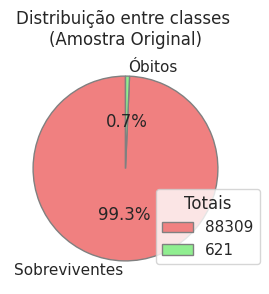

In [6]:
df = pd.read_csv(folder + 'Mortes_infantil_RJ.csv')

# Transformando dados não numéricos descritivos em categoricos
#df['CAUSABAS'] = df['CAUSABAS'].astype('category').cat.codes

df = pd.get_dummies(df, columns=['CODOCUPMAE'], prefix=['CODOCUPMAE'])
df = pd.get_dummies(df, columns=['APGAR1'], prefix=['APGAR1'])
df = pd.get_dummies(df, columns=['APGAR5'], prefix=['APGAR5'])
df = pd.get_dummies(df, columns=['CONSPRENAT'], prefix=['CONSPRENAT'])
df = pd.get_dummies(df, columns=['MESPRENAT'], prefix=['MESPRENAT'])
df = pd.get_dummies(df, columns=['SEMAGESTAC'], prefix=['SEMAGESTAC'])

df = df.drop(['DIAS_DE_VIDA', 'CAUSABAS','DT_NASC','DT_OBITO'], axis=1)

print('Dimensões', df.shape)
print()
print(df.columns)
print()

pizza(df, '\n(Amostra Original)')

# 1) Divisão do conjunto de dados

## 1.1) Divisão de conjunto de dados em Validação, Treino e Teste

O conjunto de dados possui um total 88.930 registros, sendo 88.309 da classe 0 (sobreviventes) e 621 da classe 1 (óbitos neonatais), o que significa que estamos lidando com um problema que apresenta um conjunto de dados fortemente desbalanceado entre as classes.

Para divisão do conjunto de adotada a seguinte estratégia: do conjunto inicial 20% dos dados são separados para validação final; os 80% restantes, são divididos entre dados de treino e dados de teste na proporção 80% para treino e 20% para teste. As colunas 'DIAS_DE_VIDA', 'CAUSABAS', 'DT_NASC' e 'DT_OBITO' são removidas do conjunto de dados para os experimentos desta seção. A vairável 'CAUSABAS' será avaliada individualmente em experimentos posteriores, pois sua inclusão iria superajustar o modelo, uma vez que apenas os registros de mortes possuem esta informação. Com isso os dados foram distribuidos da seguinte forma:

Subconjunto, sobreviventes, óbitos neonatais
Validação, 17671, 115
Treino, 56508, 407
Teste, 14130, 99

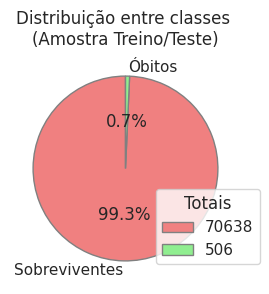

,0,1,2
,Validação,Treino,Teste
sobreviventes,17671,56508,14130
óbitos neonatais,115,407,99


In [7]:
X = df.drop(columns=['OBITO_NEONATAL'])
y = df['OBITO_NEONATAL']

# Separação de 20% do conjunto de dados inicial para validação final
X_80, X_val, y_80, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train, X_test, y_train, y_test = train_test_split(X_80, y_80, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_train.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_train.value_counts()[1], y_test.value_counts()[1]]}

pizza(pd.concat([X_80, y_80], axis=1), '\n(Amostra Treino/Teste)')

pd.DataFrame(data).T


## 1.2) Balanceamento "Undersample" por amostragem aleatória

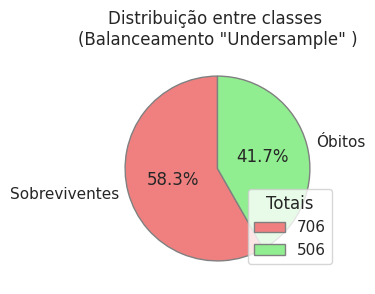

,0,1,2
,Validação,Treino,Teste
sobreviventes,87603,550,156
óbitos neonatais,115,419,87


In [8]:
df_80 = X_80.copy()
df_80['OBITO_NEONATAL'] = y_80

df_class_0 = df_80[df_80['OBITO_NEONATAL'] == 0]
X_class_0 = df_class_0.drop(columns=['OBITO_NEONATAL'])
y_class_0 = df_class_0['OBITO_NEONATAL']

df_class_1 = df_80[df_80['OBITO_NEONATAL'] == 1]
X_class_1 = df_class_1.drop(columns=['OBITO_NEONATAL'])
y_class_1 = df_class_1['OBITO_NEONATAL']

# Separação de ~1% da classe 0 pra balanceamento
X_bal, X_val_bal, y_bal, y_val_bal = train_test_split(X_class_0, y_class_0, test_size=0.99, random_state=42)

X_bal = pd.concat([X_bal, X_class_1])
y_bal = pd.concat([y_bal, y_class_1])

X_val_bal = pd.concat([X_val_bal, X_val])
y_val_bal = pd.concat([y_val_bal, y_val])

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val_bal.value_counts()[0], y_train_bal.value_counts()[0], y_test_bal.value_counts()[0]],
        'óbitos neonatais': [y_val_bal.value_counts()[1], y_train_bal.value_counts()[1], y_test_bal.value_counts()[1]]}

pizza(pd.concat([X_bal, y_bal], axis=1), '\n(Balanceamento "Undersample" )')

pd.DataFrame(data).T


## 1.3) Dados para abordagem de treinamento com classe única (SVM one class / Isolation Forest)

In [9]:
# Separate data into class 0 and class 1
class_0_data = df_80[df_80['OBITO_NEONATAL'] == 0]
class_1_data = df_80[df_80['OBITO_NEONATAL'] == 1]

# Remove target
class_0_data = class_0_data.drop(columns=['OBITO_NEONATAL'])
class_1_data = class_1_data.drop(columns=['OBITO_NEONATAL'])

# Conjunto Treino e teste apenas Classe 0
X_train_class0, X_test_class0 = train_test_split(class_0_data, test_size=0.1, random_state=42)
X_outliers = class_1_data
y_outliers = np.ones(len(X_outliers), dtype=int)

X_test_both = np.concatenate((X_train_class0, X_outliers))
y_test_both = np.concatenate((np.zeros(len(X_train_class0), dtype=int), np.ones(len(X_outliers), dtype=int)))

data = {'': ['Outliers', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], X_train_class0.shape[0], X_test_class0.shape[0]],
        'óbitos neonatais': [X_outliers.shape[0], 0,0 ]}

pd.DataFrame(data).T

,0,1,2
,Outliers,Treino,Teste
sobreviventes,17671,63574,7064
óbitos neonatais,506,0,0


## 1.4) Aplicação da técnica ENN para balanceamento "Undersample"

A técnica Edited Nearest Neighbours (ENN) é uma abordagem de subamostragem que visa identificar e remover instâncias potencialmente problemáticas de um conjunto de dados desequilibrado. Ao avaliar cada ponto de dados, o ENN examina a classe de seus vizinhos mais próximos, determinando se esses pontos são consistentes ou discordantes. Em particular, o ENN analisa a classe de cada instância e a compara com a classe de seus vizinhos mais próximos. Se a maioria dos vizinhos mais próximos de uma instância pertence a uma classe diferente da sua, ela é considerada potencialmente ruidosa e é removida do conjunto de dados.

Esta técnica utiliza a distância euclidiana ou outra métrica de distância para identificar vizinhos mais próximos. Ao remover instâncias inconsistentes, o ENN busca melhorar a qualidade do conjunto de dados de treinamento, removendo informações redundantes ou contraditórias que podem prejudicar o processo de aprendizado do modelo. No entanto, é essencial considerar o impacto da remoção de instâncias em conjunto com o equilíbrio entre as classes e a perda potencial de informações importantes.

Existem várias abordagens para lidar com conjuntos de dados desbalanceadas. Vamos aplicar duas estratégias para fins de comparação e análise. A primeira delas será aplicar uma técnica para reduzir o número de amostras da classe majoritária, conhecida como "undersample". Vamos aplicar duas estratégias, a primeira fazendo uma redução por amostragem, o que preserva a distribuição dos dados, porém podendo descartar amostras relevantes, e outra um método sistematico, que será a técnica de Edited Nearest Neighbours (ENN).

Está técnica apresenta vantagens substanciais em relação ao undersample aleatório em contextos de conjuntos de dados desequilibrados. Ao remover seletivamente exemplos que estão próximos das fronteiras das classes, o ENN preserva informações cruciais enquanto reduz o viés de classe. Isso resulta em uma distribuição de dados mais fiel à original, o que é crucial para manter a representatividade das classes e evitar a perda de informações críticas. Além disso, o ENN mitiga o impacto no desempenho do modelo ao manter uma quantidade significativa de dados, permitindo que o modelo aprenda relações mais precisas entre as classes. Esta abordagem oferece um equilíbrio entre a redução de dados e a preservação de informações valiosas, tornando-o uma ferramenta eficaz para lidar com o desbalanceamento de conjuntos de dados.

In [10]:

file_path = folder + 'X_enn.pkl'

# Ler os arrays de arquivos pickle caso existam
if os.path.exists(file_path):
  with open(folder + 'X_enn.pkl', 'rb') as file:
      X_enn = pickle.load(file)

  with open(folder + 'y_enn.pkl', 'rb') as file:
      y_enn = pickle.load(file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'rb') as file:
      enn_sample_indices = pickle.load(file)
# Caso não existam, gerar e salvar
else:
  enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=500)
  X_enn, y_enn = enn.fit_resample(X_80, y_80)

  # Salvar os arrays em arquivos pickle
  with open(folder + 'X_enn.pkl', 'wb') as file:
      pickle.dump(X_enn, file)

  with open(folder + 'y_enn.pkl', 'wb') as file:
      pickle.dump(y_enn, file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'wb') as file:
      pickle.dump(enn.sample_indices_, file)

print(y_enn.value_counts())


0    25087
1      506
Name: OBITO_NEONATAL, dtype: int64


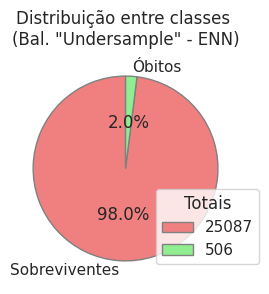

,0,1,2
,Validação,Treino,Teste
sobreviventes,63222,20068,5019
óbitos neonatais,115,406,100


In [11]:

# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, test_size=0.20, random_state=42)

X_val_enn = X_80.drop(index=X_80.index[enn_sample_indices])
y_val_enn = y_80.drop(index=y_80.index[enn_sample_indices])

X_val_enn = pd.concat([X_val_enn, X_val])
y_val_enn = pd.concat([y_val_enn, y_val])

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val_enn.value_counts()[0], y_train_enn.value_counts()[0], y_test_enn.value_counts()[0]],
        'óbitos neonatais': [y_val_enn.value_counts()[1], y_train_enn.value_counts()[1], y_test_enn.value_counts()[1]]}

pizza(pd.concat([X_enn, y_enn], axis=1), '\n(Bal. "Undersample" - ENN)')

pd.DataFrame(data).T


## 1.5) Balanceamento "Oversample" ADASUYN

In [12]:
adasyn = ADASYN()
# Direto antes do método

## 1.6) Normalização de features

In [13]:
# Store the feature names before scaling
feature_names = X_80.columns.tolist()

# If True refresh datafiles, else load from storage
if True :
  # Normalização
  scaler = MinMaxScaler()

  # Base 80/20
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  X_val = scaler.fit_transform(X_val)

  # Base balanceada Undersampling
  X_train_bal = scaler.fit_transform(X_train_bal)
  X_test_bal = scaler.fit_transform(X_test_bal)
  X_val_bal = scaler.fit_transform(X_val_bal)

  # Base balanceada Undersampling ENN
  X_train_enn = scaler.fit_transform(X_train_enn)
  X_test_enn = scaler.fit_transform(X_test_enn)
  X_val_enn = scaler.fit_transform(X_val_enn)

  # Save data
  with open(folder + 'X_train.pkl', 'wb') as f:
      pickle.dump(X_train, f)

  with open(folder + 'X_test.pkl', 'wb') as f:
      pickle.dump(X_test, f)

  with open(folder + 'X_val.pkl', 'wb') as f:
      pickle.dump(X_val, f)

  # Save Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'wb') as f:
      pickle.dump(X_train_bal, f)

  with open(folder + 'X_test_bal.pkl', 'wb') as f:
      pickle.dump(X_test_bal, f)

  with open(folder + 'X_val_bal.pkl', 'wb') as f:
      pickle.dump(X_val_bal, f)

  # Save Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'wb') as f:
      pickle.dump(X_train_enn, f)

  with open(folder + 'X_test_enn.pkl', 'wb') as f:
      pickle.dump(X_test_enn, f)

  with open(folder + 'X_val_enn.pkl', 'wb') as f:
      pickle.dump(X_val_enn, f)

# Load from storge
else:
  # Load Base 80/20
  with open(folder + 'X_train.pkl', 'rb') as f:
      X_train = pickle.load(f)

  with open(folder + 'X_test.pkl', 'rb') as f:
      X_test = pickle.load(f)

  with open(folder + 'X_val.pkl', 'rb') as f:
      X_val = pickle.load(f)

  # Load Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'rb') as f:
      X_train_bal = pickle.load(f)

  with open(folder + 'X_test_bal.pkl', 'rb') as f:
      X_test_bal = pickle.load(f)

  with open(folder + 'X_val_bal.pkl', 'rb') as f:
      X_val_bal = pickle.load(f)

  # Load Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'rb') as f:
      X_train_enn = pickle.load(f)

  with open(folder + 'X_test_enn.pkl', 'rb') as f:
      X_test_enn = pickle.load(f)

  with open(folder + 'X_val_enn.pkl', 'rb') as f:
      X_val_enn = pickle.load(f)


# -- **EXPERIMENTOS** --

# E1: Regressão Logística

## **Descrição**


Este código realiza a classificação usando um modelo de regressão logística simples, avalia o desempenho do modelo e gera visualizações para a curva ROC, a importância das features e os valores SHAP.

O código começa dividindo o conjunto de dados em conjuntos de treinamento e teste, essenciais para avaliar o desempenho do modelo. Em seguida, ele cria um modelo de classificação de Regressão Logística, que é um método amplamente utilizado para problemas de classificação binária. O modelo é treinado usando os dados de treinamento e usado para fazer previsões nos dados de teste.

Avaliando o desempenho, o código calcula a acurácia do modelo, que é a proporção de previsões corretas em relação ao total de previsões. Também calcula a Área sob a Curva ROC (AUC-ROC), que mede a capacidade do modelo de distinguir entre classes positivas e negativas. Os resultados são satisfatórios se a acurácia for alta e o AUC-ROC estiver próximo de 1, indicando que o modelo está fazendo previsões precisas.

Além disso, o código gera gráficos informativos. A curva ROC mostra o equilíbrio entre a taxa de falsos positivos e a taxa de verdadeiros positivos, enquanto o gráfico de importância das features destaca quais características têm maior influência nas previsões do modelo. Por fim, os valores SHAP são calculados para explicar a contribuição de cada feature em cada previsão.

Em resumo, o código apresenta um modelo de Regressão Logística para classificação binária e avalia seu desempenho usando métricas como acurácia e AUC-ROC, ao mesmo tempo em que fornece insights visuais sobre a importância das features e os valores SHAP. Estas análises são fundamentais para entender como o modelo toma suas decisões e quais características são mais relevantes para as previsões.

## E1-a: Regressão Logística - Baseline

-------------------------------------------------------------
E1-a : Modelo de Regressão Logística - Baseline
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    14130
1             1       0.69    0.29      0.41       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.84    0.65      0.70    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


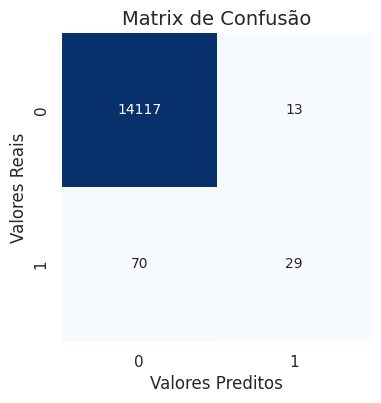

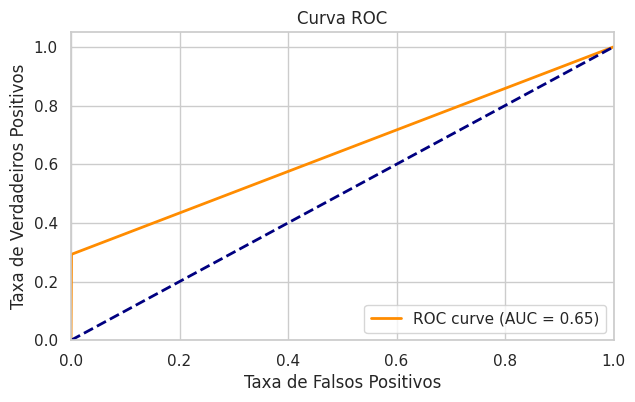


LogisticRegression


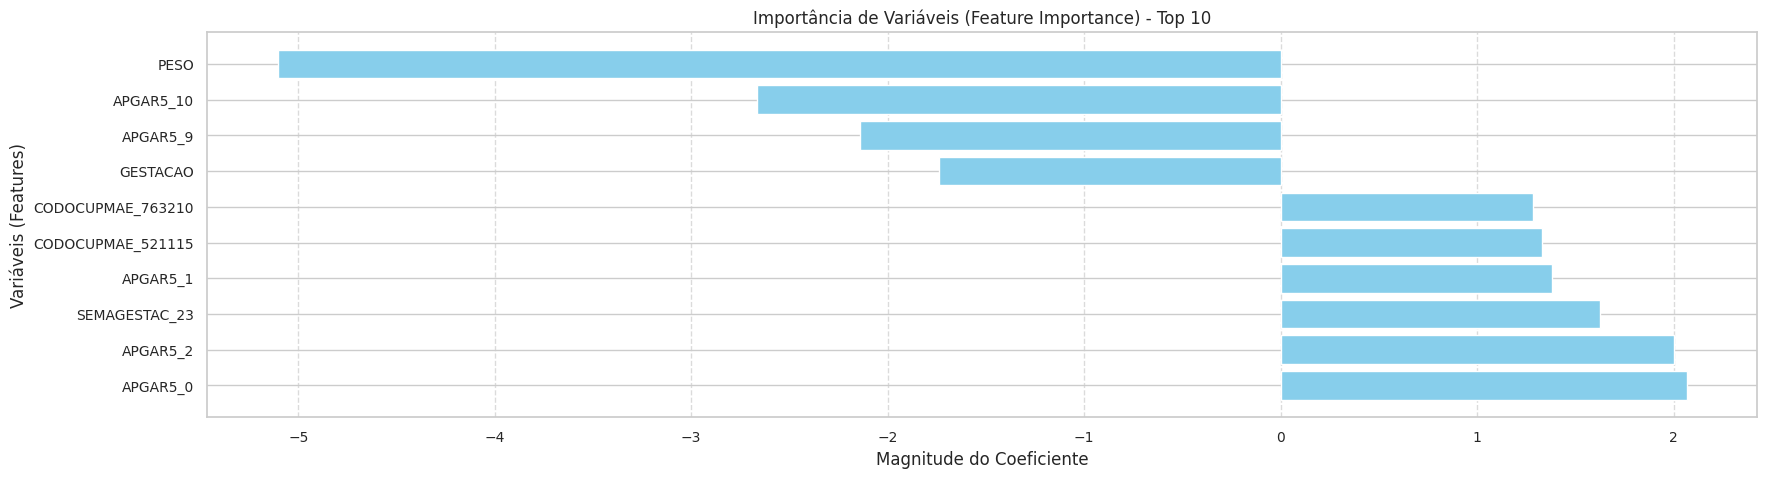

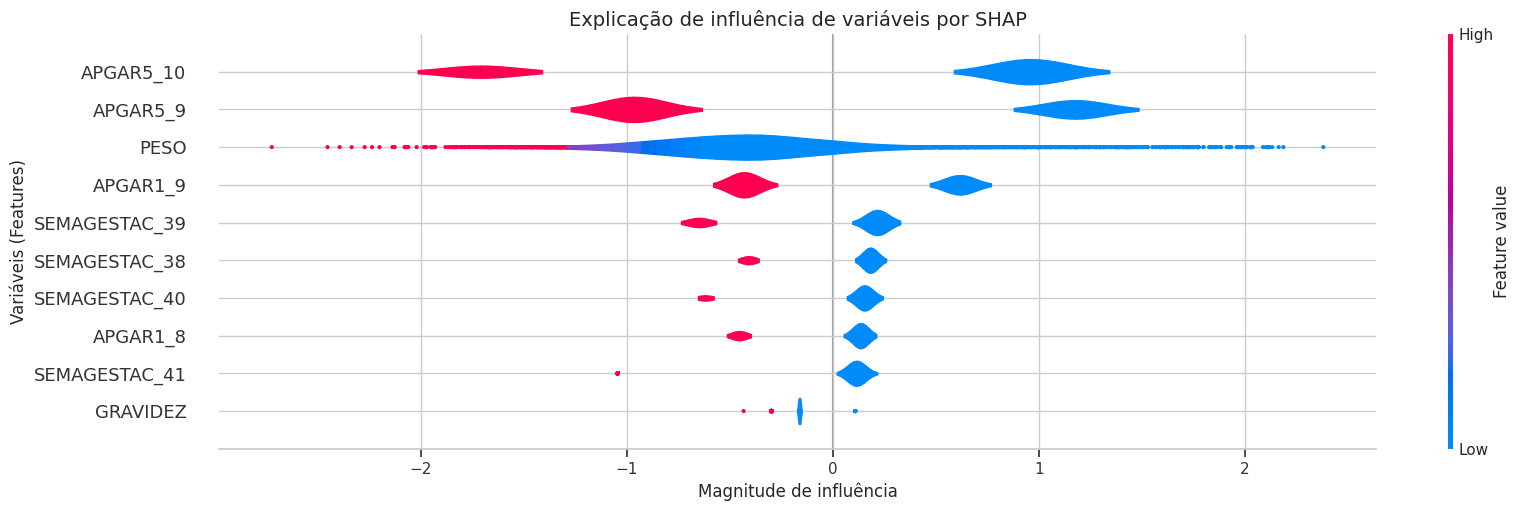


-------------------------------------------------------------
E1-aV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17671
1             1       0.64    0.31      0.42      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.82    0.66      0.71    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------


In [14]:
final_report, E1_a = run_experiment('E1-a : Modelo de Regressão Logística - Baseline',
                              LogisticRegression(random_state=42,  max_iter=1000),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


## E1-b: Regressão Logística - Balanceamento "Undersample" com amostragem aleatória

-------------------------------------------------------------
E1-b : Modelo de Regressão Logística - Balanceamento "Undersample" com amostragem aleatória
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.89    0.96      0.92      156
1             1       0.91    0.79      0.85       87
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.90    0.87      0.88      243
4  weighted avg       0.90    0.90      0.90      243
-------------------------------------------------------------


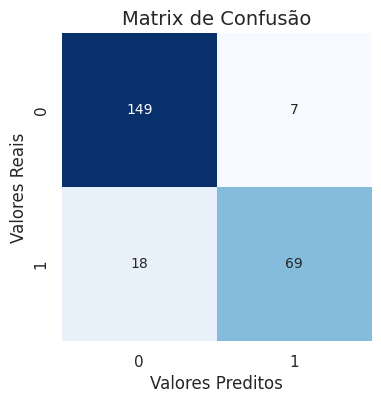

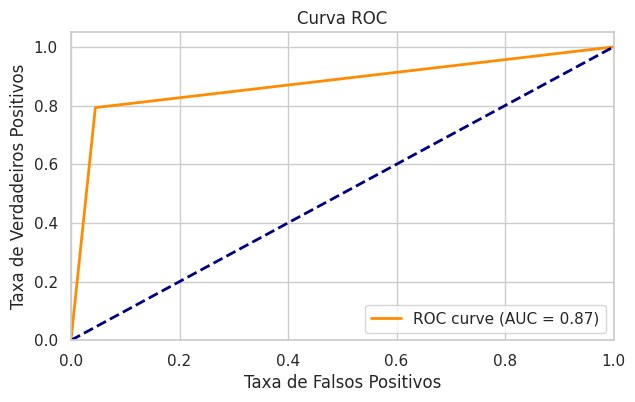


LogisticRegression


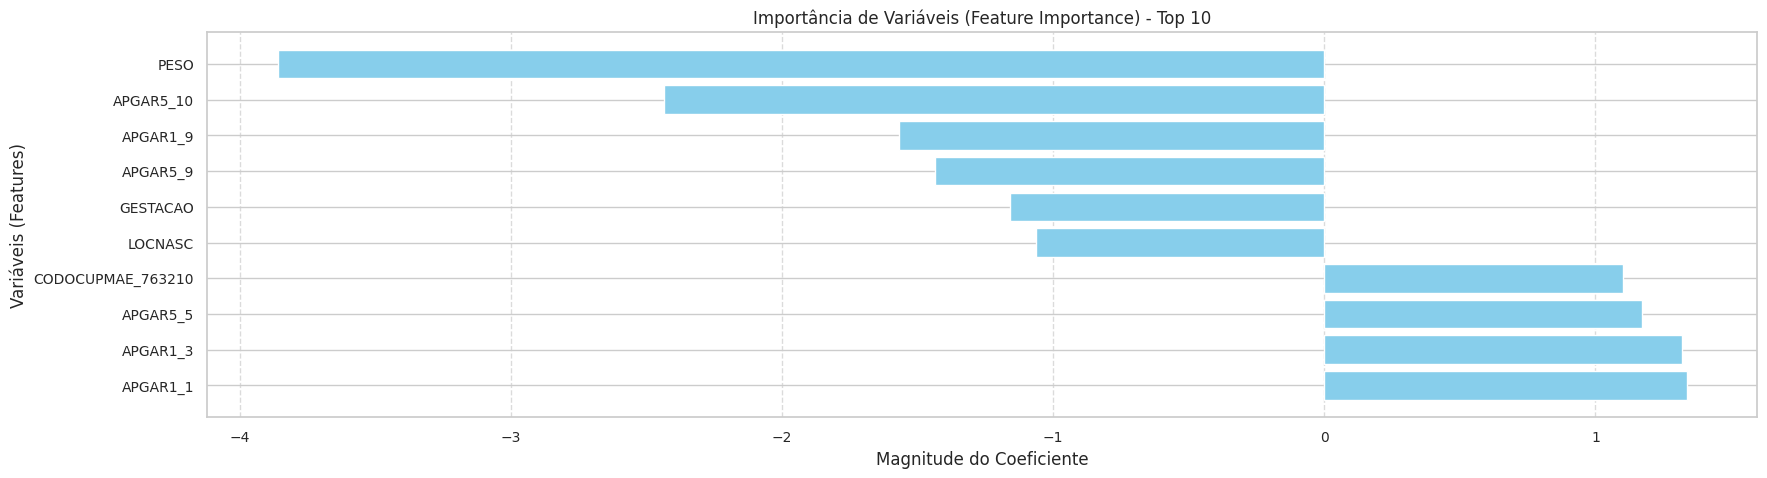

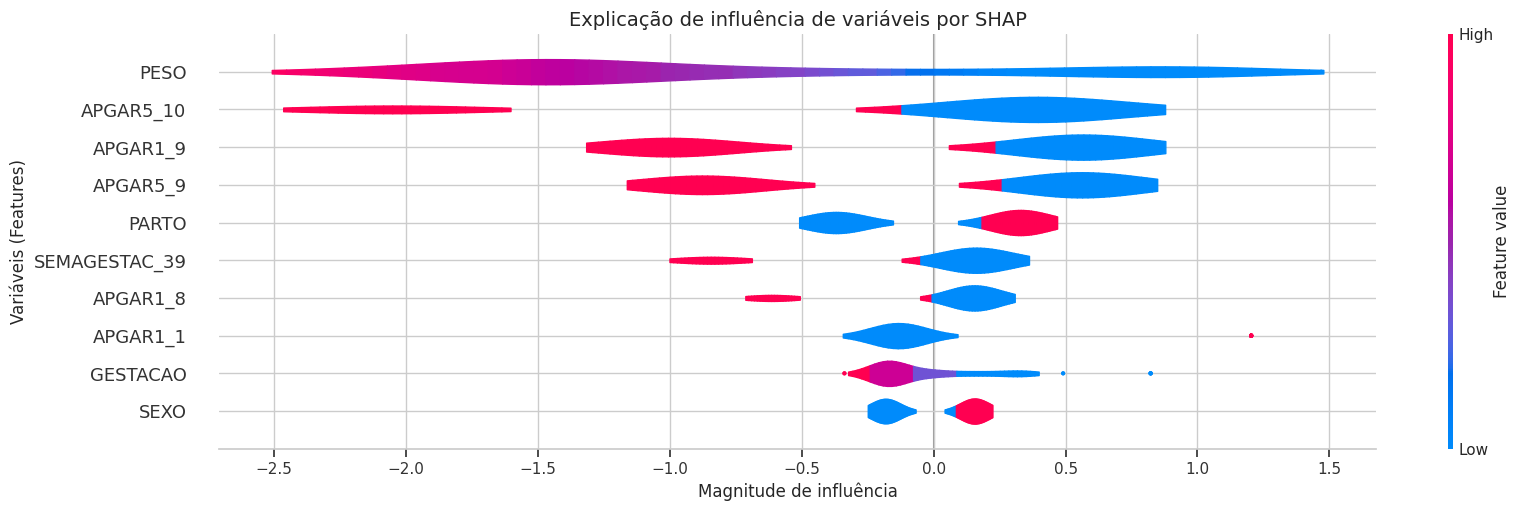


-------------------------------------------------------------
E1-bV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.92      0.96    87603
1             1       0.01    0.80      0.03      115
2      accuracy       0.92    0.92      0.92        0
3     macro avg       0.51    0.86      0.49    87718
4  weighted avg       1.00    0.92      0.96    87718
-------------------------------------------------------------


In [15]:
final_report, E1_b = run_experiment('E1-b : Modelo de Regressão Logística - Balanceamento "Undersample" com amostragem aleatória',
                              LogisticRegression(random_state=42,  max_iter=1000),
                              X_train_bal, y_train_bal, X_test_bal, y_test_bal, X_val_bal, y_val_bal,
                              final_report)

## E1-c: Regressão Logística - Validação Cruzada


-------------------------------------------------------------
E1-c : Modelo de Regressão Logística - Validação Cruzada
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    14130
1             1       0.69    0.24      0.36       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.84    0.62      0.68    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


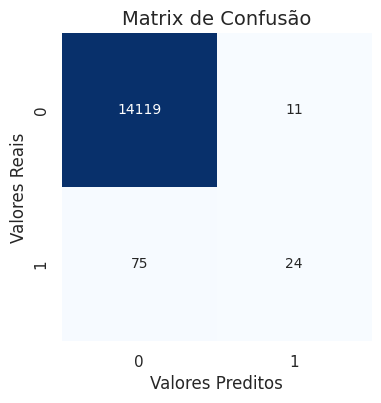

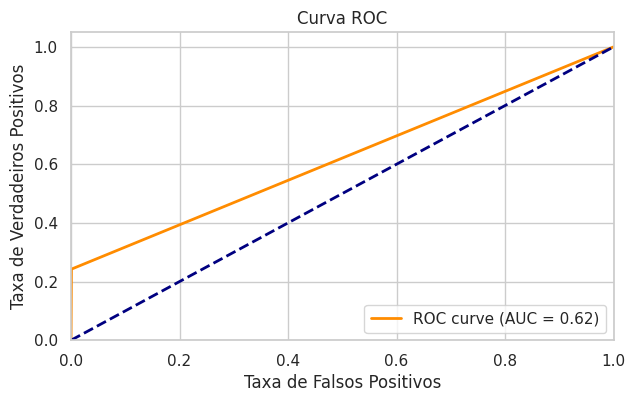


LogisticRegressionCV


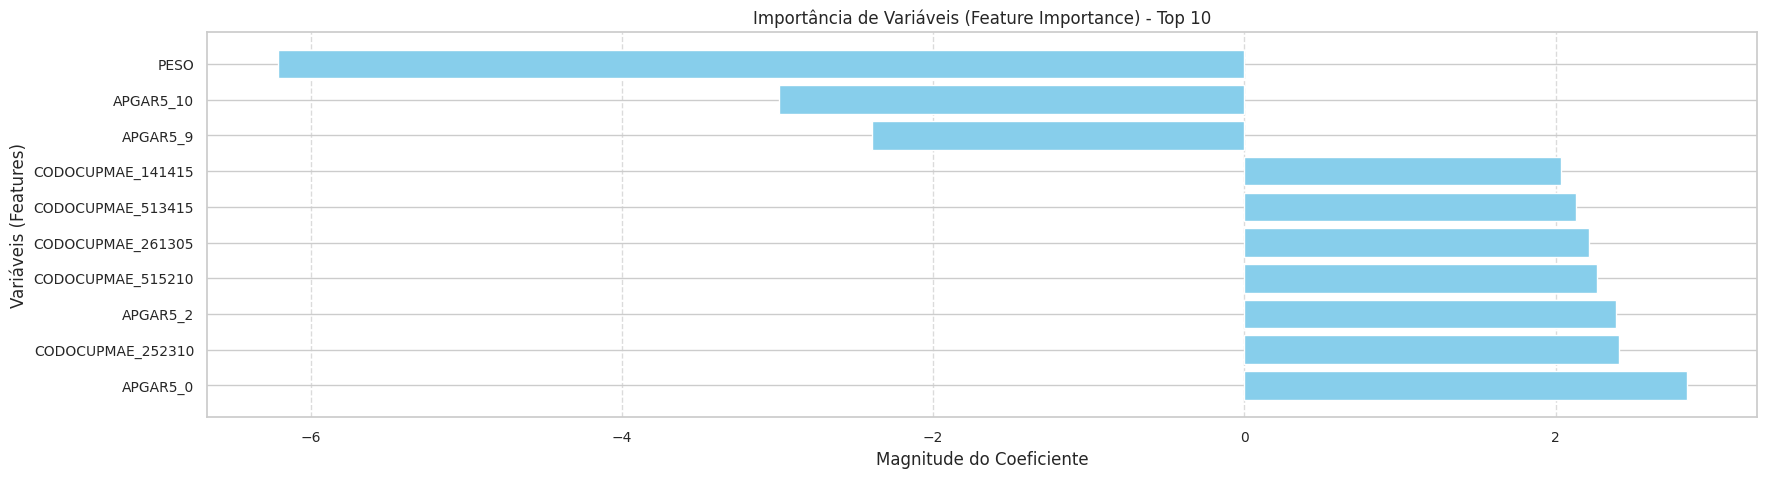

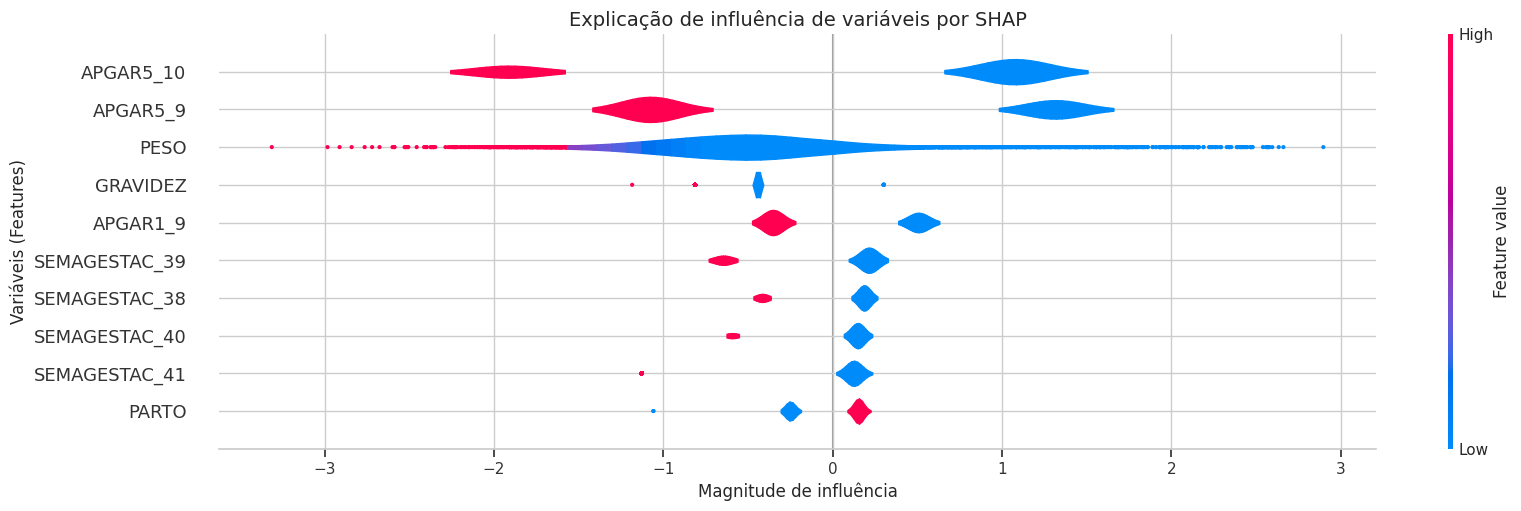


-------------------------------------------------------------
E1-cV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17671
1             1       0.65    0.30      0.41      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.82    0.65      0.71    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------


In [16]:
final_report, E1_c= run_experiment('E1-c : Modelo de Regressão Logística - Validação Cruzada',
                              LogisticRegressionCV(random_state=42,  max_iter=1000),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E1-d: Regressão Logística - Balanceamento "Undersample" ENN

-------------------------------------------------------------
E1-d : Modelo de Regressão Logística - Balanceamento "Undersample" com ENN
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00     5019
1             1       0.89    0.86      0.87      100
2      accuracy       1.00    1.00      1.00        1
3     macro avg       0.94    0.93      0.94     5119
4  weighted avg       1.00    1.00      1.00     5119
-------------------------------------------------------------


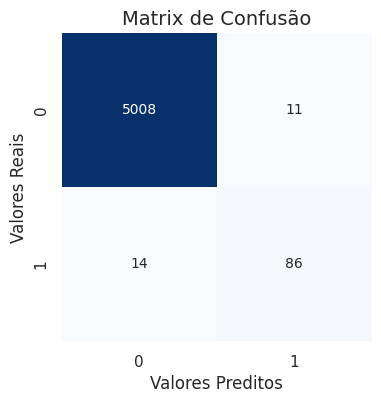

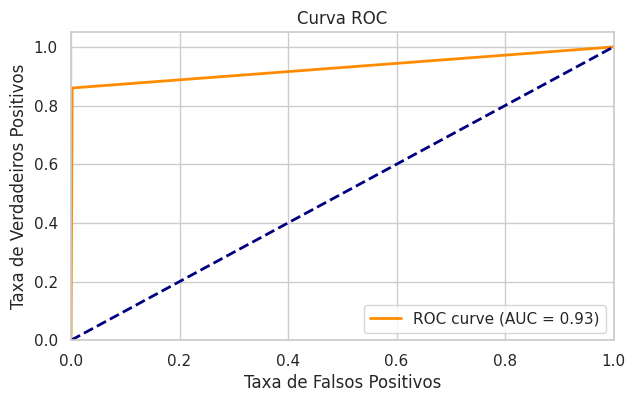


LogisticRegressionCV


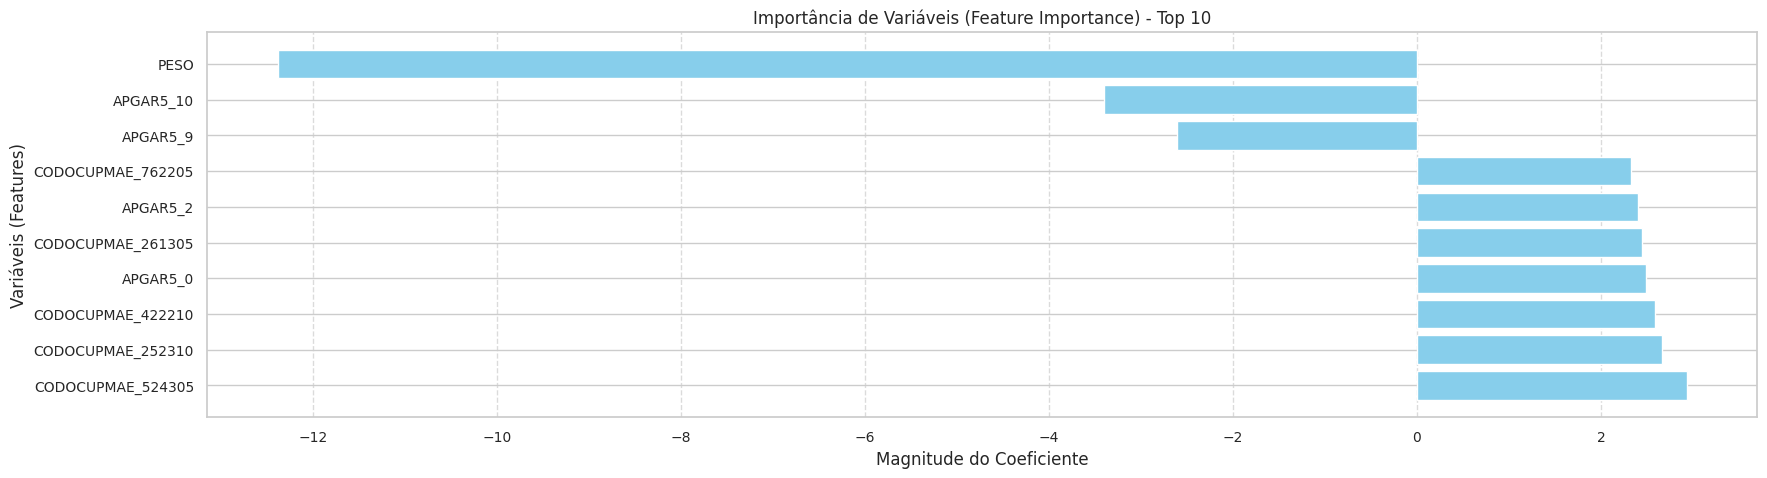

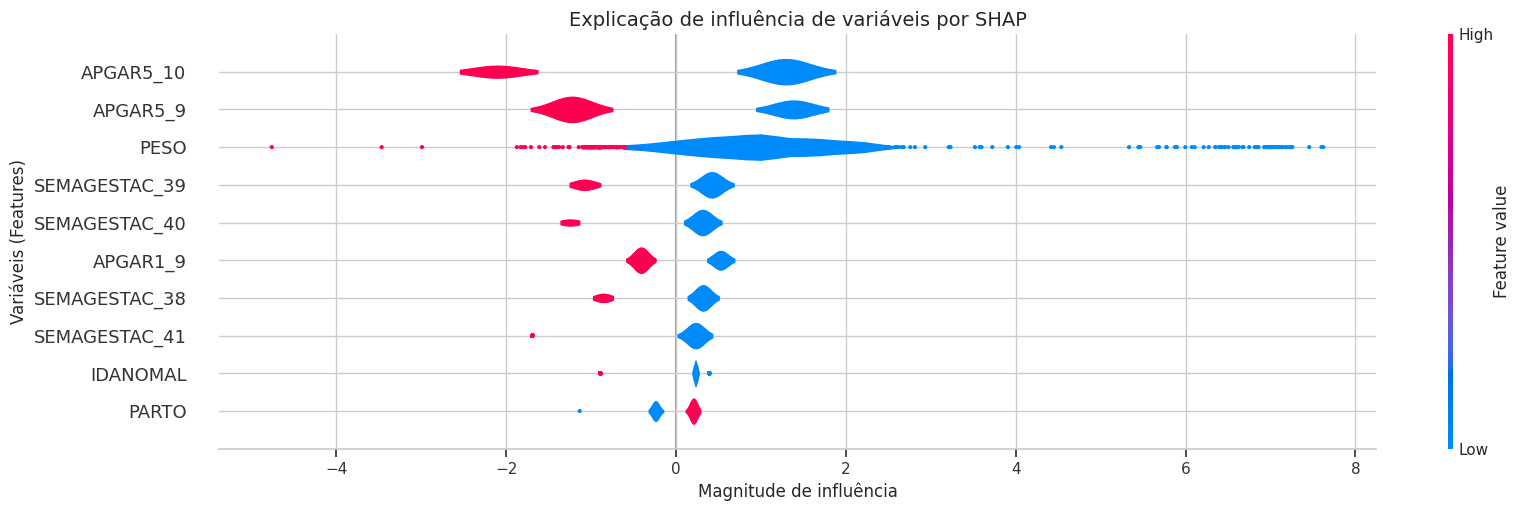


-------------------------------------------------------------
E1-dV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.96      0.98    63222
1             1       0.03    0.74      0.06      115
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.51    0.85      0.52    63337
4  weighted avg       1.00    0.95      0.98    63337
-------------------------------------------------------------


In [17]:
final_report, E1_d = run_experiment('E1-d : Modelo de Regressão Logística - Balanceamento "Undersample" com ENN',
                              LogisticRegressionCV(random_state=42,  max_iter=1000),
                              X_train_enn, y_train_enn, X_test_enn, y_test_enn, X_val_enn, y_val_enn,
                              final_report)

## E1-e: Regressão Logística - Peso paramétrico

-------------------------------------------------------------
E1-e : Modelo de Regressão Logística - Peso Paramétrico
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    14130
1             1       0.65    0.31      0.42       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.82    0.66      0.71    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


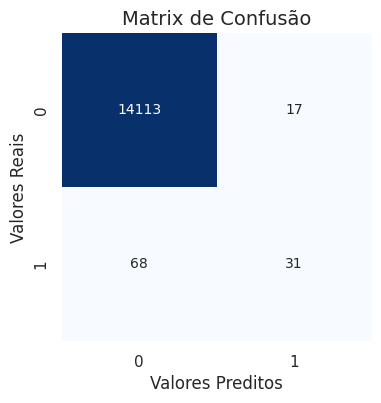

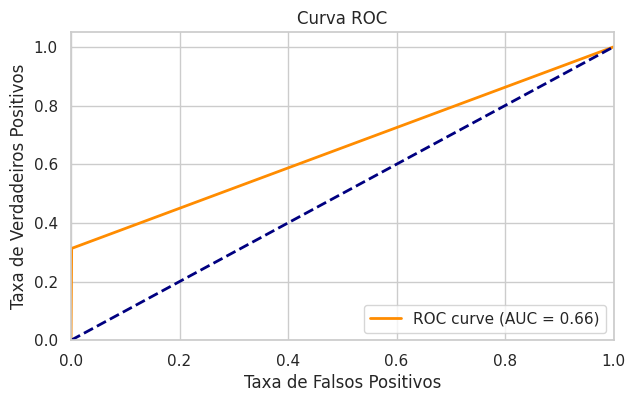


LogisticRegressionCV


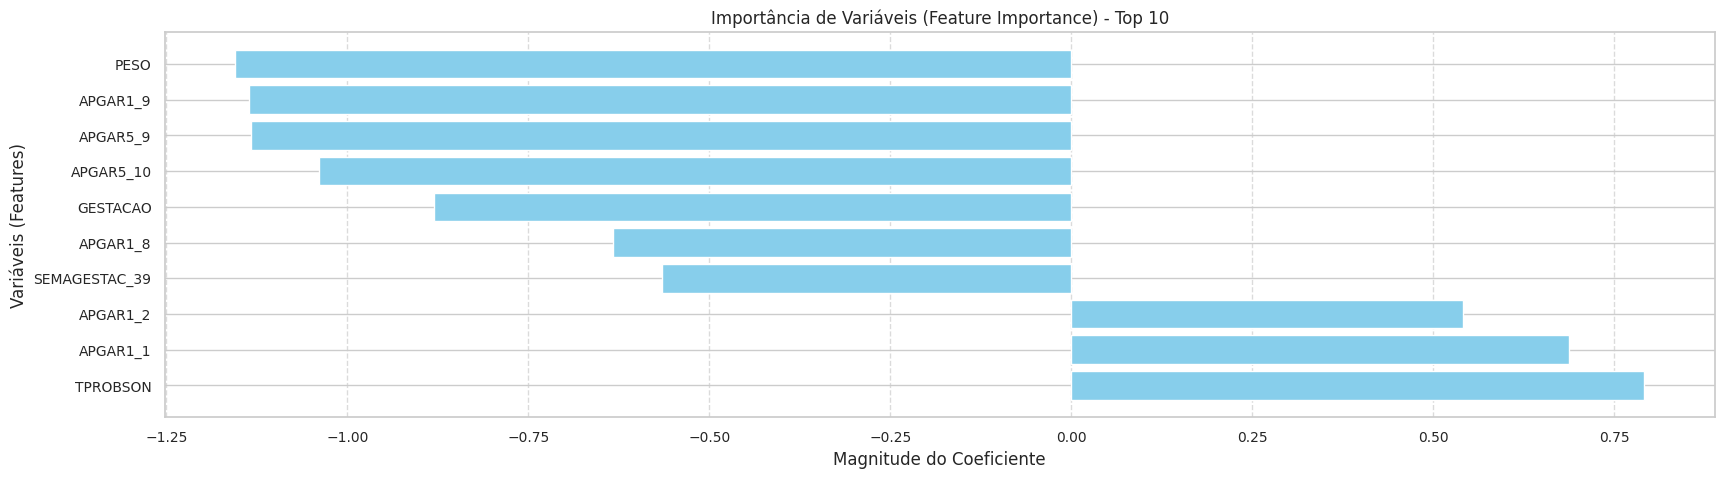

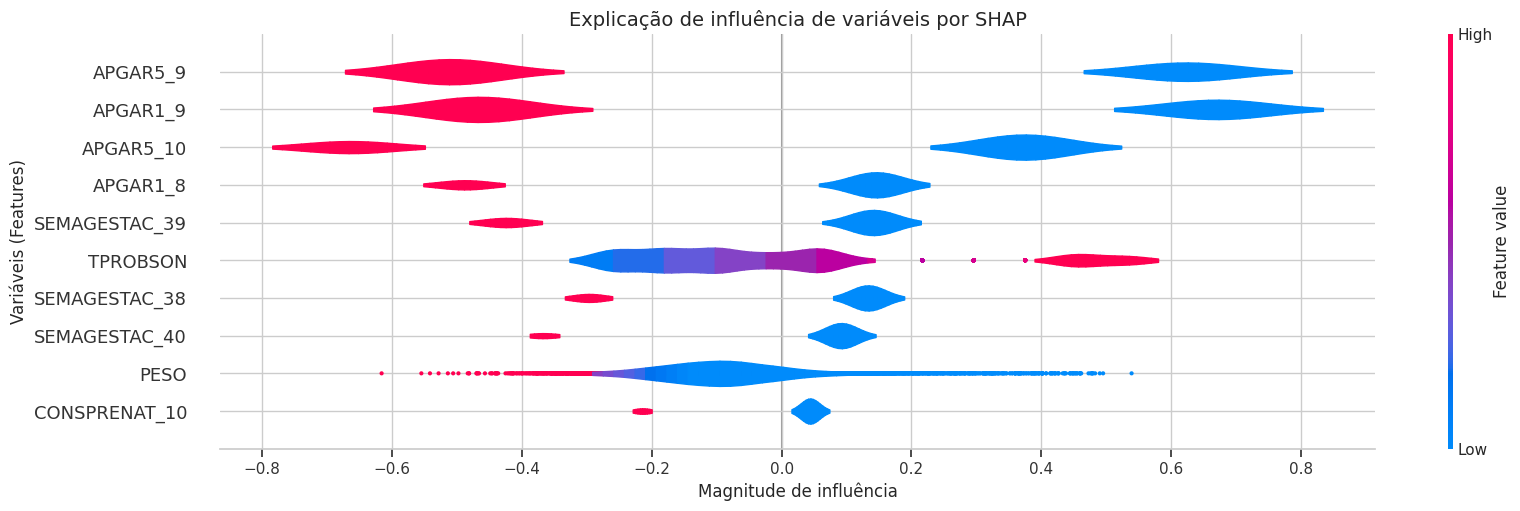


-------------------------------------------------------------
E1-eV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17671
1             1       0.60    0.34      0.43      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.80    0.67      0.72    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------


In [18]:
final_report, E1_e = run_experiment('E1-e : Modelo de Regressão Logística - Peso Paramétrico',
                              LogisticRegressionCV(random_state=42, class_weight={0: 1, 1: 5}, max_iter=1000),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E1-f: Regressão Logística - Balanceamento "Oversample" ADASYN

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


-------------------------------------------------------------
E1-f: Regressão Logística - Balanceamento "Oversample" ADASYN
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    14130
1             1       0.47    0.35      0.40       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.73    0.68      0.70    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


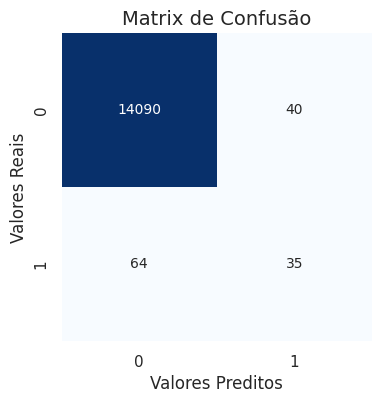

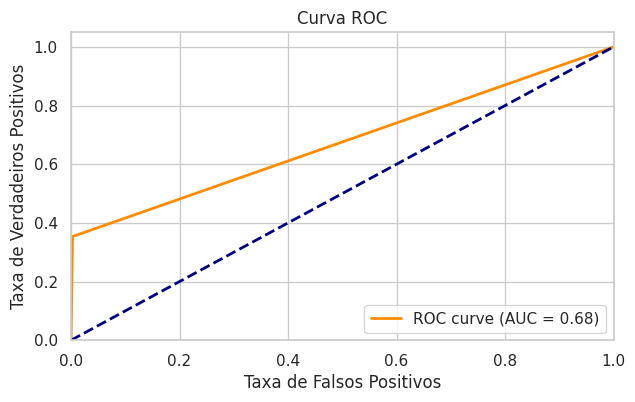


LogisticRegressionCV


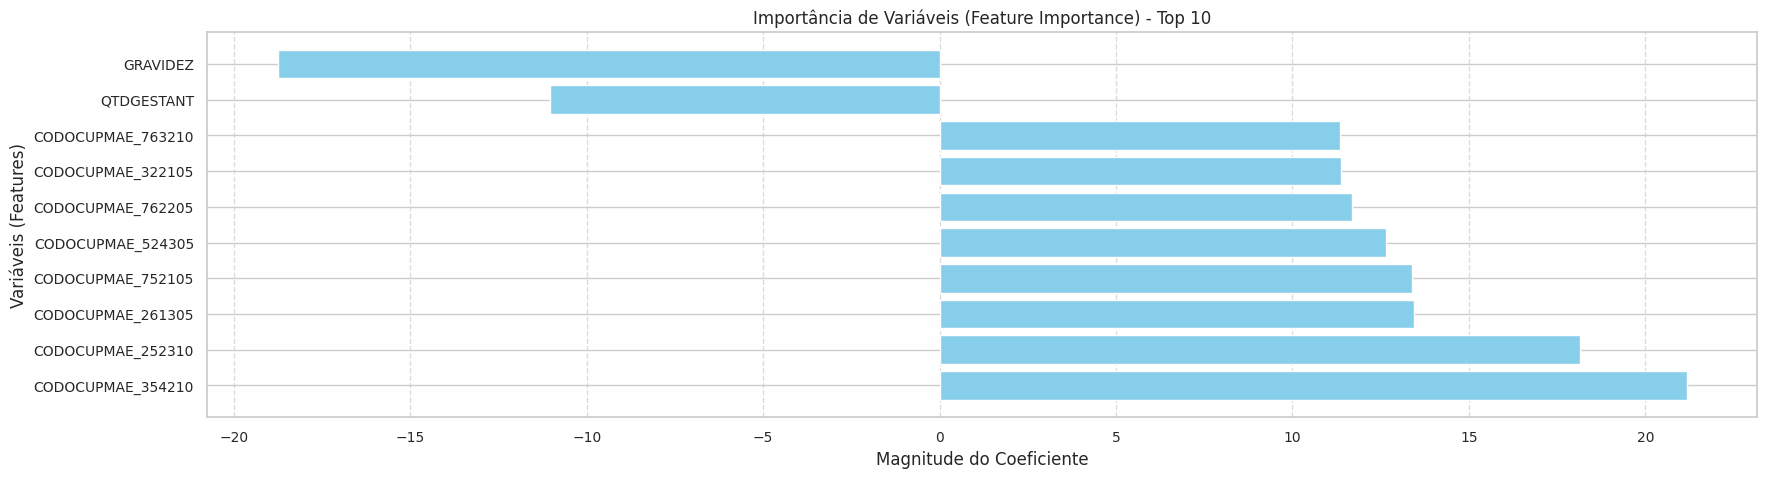

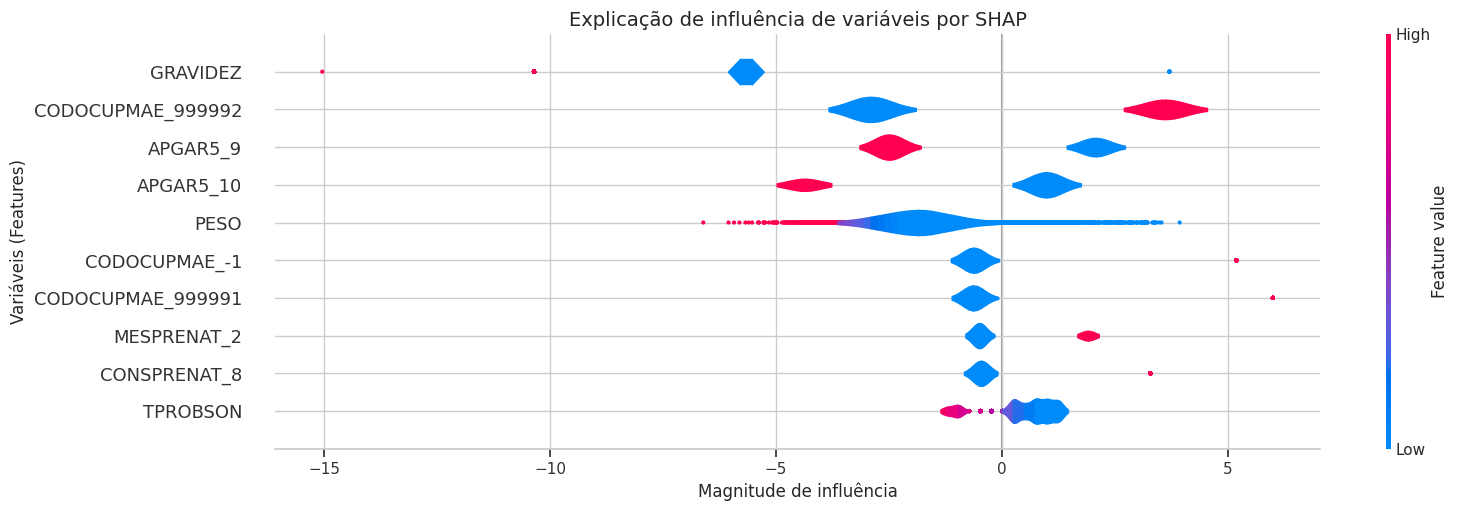


-------------------------------------------------------------
E1-fV: Validação
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17671
1             1       0.43    0.37      0.40      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.72    0.69      0.70    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------


In [19]:
X_over, y_over = adasyn.fit_resample(X_train, y_train)

final_report, E1_f = run_experiment('E1-f: Regressão Logística - Balanceamento "Oversample" ADASYN',
                              LogisticRegressionCV(random_state=42, max_iter=200),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

## E1: Avaliação de Precison/Recall ROC..

In [20]:
final_report[-20:]

,#,index,precision,recall,f1-score,support,Descrição
40,E1-e,0,1.00,1.00,1.00,14130,E1-e : Modelo de Regressão Logística - Peso Pa...
41,E1-e,1,0.65,0.31,0.42,99,E1-e : Modelo de Regressão Logística - Peso Pa...
42,E1-e,accuracy,0.99,0.99,0.99,0,E1-e : Modelo de Regressão Logística - Peso Pa...
43,E1-e,macro avg,0.82,0.66,0.71,14229,E1-e : Modelo de Regressão Logística - Peso Pa...
44,E1-e,weighted avg,0.99,0.99,0.99,14229,E1-e : Modelo de Regressão Logística - Peso Pa...
45,E1-eV,0,1.00,1.00,1.00,17671,E1-eV: Validação
46,E1-eV,1,0.60,0.34,0.43,115,E1-eV: Validação
47,E1-eV,accuracy,0.99,0.99,0.99,0,E1-eV: Validação
48,E1-eV,macro avg,0.80,0.67,0.72,17786,E1-eV: Validação
49,E1-eV,weighted avg,0.99,0.99,0.99,17786,E1-eV: Validação


In [21]:
'''
y_pred_prob_test = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_val = logistic_regression_model.predict_proba(X_val_scaled)[:, 1]


#####

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_test)
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



##########


y_test_list = y_test.tolist()
y_pred_prob_test_list = y_pred_prob_test.tolist()

# Crie um dicionário para passar ao DataFrame
data = {'y_test': y_test_list, 'y_pred_prob_test': y_pred_prob_test_list}

# Crie o DataFrame a partir do dicionário
df = pd.DataFrame(data)

# Visualize o DataFrame
df_sorted = df[df['y_test'] == 1].sort_values('y_pred_prob_test')

df_sorted.reset_index(drop=True, inplace=True)

# Plotar os dados ordenados
df_sorted['y_pred_prob_test'].plot()

##############

y_test_list = y_test.tolist()
y_pred_prob_test_list = y_pred_prob_test.tolist()

# Crie um dicionário para passar ao DataFrame
data = {'y_test': y_test_list, 'y_pred_prob_test': y_pred_prob_test_list}

# Crie o DataFrame a partir do dicionário
df = pd.DataFrame(data)

# Visualize o DataFrame
df_sorted = df[df['y_test'] == 0].sort_values('y_pred_prob_test')

df_sorted.reset_index(drop=True, inplace=True)

# Plotar os dados ordenados
df_sorted[df_sorted['y_pred_prob_test'] > 0.1]['y_pred_prob_test'].plot()
'''

NameError: ignored

# E2 - Naive Bayes

## E2-a: Modelo Naive Bayes - ComplementNB - Baseline


In [ ]:
final_report, E2_a = run_experiment('E2-a : Modelo Naive Bayes - Baseline',
                              ComplementNB(),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


## E2-b: Modelo Naive Bayes - ComplementNB - Prioridade de Classes


In [ ]:
final_report, E2_b = run_experiment('E2-b : Modelo Naive Bayes - Prioridade de Classes',
                              ComplementNB(class_prior=np.array([0.99, 0.01])),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


## E2-c: Modelo Naive Bayes - MultinomialNB


In [ ]:
final_report, E2_c = run_experiment('E2-c : Modelo Naive Bayes - Baseline',
                              MultinomialNB(),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


## E2-d: Modelo Naive Bayes - MultinomialNB - Undersample ENN


In [ ]:
final_report, E2_d = run_experiment('E2-d : Modelo Naive Bayes - Undersample',
                              MultinomialNB(class_prior=np.array([0.99, 0.01])),
                              X_train_enn, y_train_enn, X_test_enn, y_test_enn, X_val_enn, y_val_enn,
                              final_report)

## E2-e: Modelo Naive Bayes - MultinomialNB - Oversample


In [ ]:
X_over, y_over = adasyn.fit_resample(X_train, y_train)

final_report, E2_d = run_experiment('E2-e : Modelo Naive Bayes - Oversample',
                              MultinomialNB(class_prior=np.array([0.99, 0.01])),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

# E3: Extreme Gradient Boosting

## E3-a : Modelo XGBoost - Baseline

In [ ]:
final_report, E3_a = run_experiment('E3-a : Modelo XGBoost - Baseline',
                              xgb.XGBClassifier(random_state=42),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-b : Modelo XGBoost - Balancemanto Undersample aleatório



In [ ]:
final_report, E3_b = run_experiment('E3-b : Modelo XGBoost - Balanceamento ENN',
                              xgb.XGBClassifier(random_state=42),
                              X_train_bal, y_train_bal, X_test_bal, y_test_bal, X_val_bal, y_val_bal,
                              final_report)

## E3-c : Modelo XGBoost - Balancemanto Undersample ENN



In [ ]:
final_report, E3_c = run_experiment('E3-c : Modelo XGBoost - Balanceamento ENN',
                              xgb.XGBClassifier(random_state=42),
                              X_train_enn, y_train_enn, X_test_enn, y_test_enn, X_val_enn, y_val_enn,
                              final_report)

## E3-d : Modelo XGBoost - Peso paramétrico

In [ ]:
final_report, E3_d = run_experiment('E3-d : Modelo XGBoost - Balanceamento ENN',
                              xgb.XGBClassifier(random_state=42, scale_pos_weight=100),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-e : Modelo XGBoost - Oversample

In [ ]:
X_over, y_over = adasyn.fit_resample(X_train, y_train)

final_report, E2_d = run_experiment('E3-e : Modelo XGBoost - Oversample',
                              xgb.XGBClassifier(random_state=42),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

In [ ]:
final_report.to_csv(folder + 'final_report.csv', index=False)

In [ ]:
final_report[final_report['index'] == '1'].sort_values(by='f1-score', ascending=False)

# E4: Support Vector Machine One Class

In [ ]:
# Conjunto Treino e teste apenas Classe 0
X_train_class0, X_test_class0 = train_test_split(class_0_data, test_size=0.1, random_state=42)
X_outliers = class_1_data
y_outliers = np.ones(len(X_outliers), dtype=int)

X_test_both = np.concatenate((X_test_class0, X_outliers))
y_test_both = np.concatenate((np.zeros(len(X_test_class0), dtype=int), np.ones(len(X_outliers), dtype=int)))


#This estimator has a linear complexity in the number of training samples and is
#thus better suited than the sklearn.svm.OneClassSVM implementation for datasets

# with a large number of training samples (say > 10,000).

from sklearn import linear_model
cfl = linear_model.SGDOneClassSVM(nu=0.1, random_state=42)

final_report = run_experiment('E4-a : Modelo One Class SVM',
                              #svm.OneClassSVM(nu=0.1, kernel="rbf", gamma='auto'),
                              cfl,
                              X_train_class0, np.zeros(len(X_test_class0), dtype=int), X_test_both, y_test_both, None, None,
                              final_report)

In [ ]:
# 1h pra treinar
myOneClassSVM = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma='auto').fit(scaler.fit_transform(X_train))

# Teste

predictions = myOneClassSVM.predict(scaler.fit_transform(X_test_both))
predictions = [1 if i==-1 else 0 for i in predictions]

print(classification_report(y_test_both, predictions, zero_division=1))

cm = confusion_matrix(y_test_both, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# 4788 / 4

# E5: Isolation Forest

In [ ]:

# Conjunto Treino e teste apenas Classe 0
X_train, X_test = train_test_split(class_0_data.sample(frac=1), test_size=0.99, random_state=42) # DEFINIR AQUI !!!!!
X_outliers = class_1_data
y_outliers = np.ones(len(X_outliers), dtype=int)

X_test_both = np.concatenate((X_test, X_outliers))
y_test_both = np.concatenate((np.zeros(len(X_test), dtype=int), np.ones(len(X_outliers), dtype=int)))

# Model
myIsolationForest = IsolationForest(contamination=0.5, max_features=X_train.shape[1]).fit(X_train)

predictions = myIsolationForest.predict(X_test_both)
predictions = [1 if i==-1 else 0 for i in predictions]

print(classification_report( y_test_both, predictions, zero_division=1))

cm = confusion_matrix( y_test_both, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# **AVALIAÇÃO DE CAUSAS BÁSICAS**

# Clusterização